In [1]:
%pip install face-alignment

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [2]:
import cv2 as cv
import math
from face_alignment import FaceAlignment
from face_alignment import LandmarksType
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from PIL import Image
import os
import torch
from torchvision.transforms import functional as TF
import torchvision.transforms as transforms

# Data analysis

- Show the number of frames contained in each sequence

- Show the sequence frames along with the Prkachin and Solomon Pain Intensity (PSPI) score of each frame in a graph

- Show the number of the sequence that are labeled as no pain, medium pain and severe pain in a histogram




In [3]:
import os
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [4]:
data_root = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"

if os.path.exists(data_root):
    print("Path is found.",sep=' ', end=' ', flush=True)
    if os.scandir(data_root):
        print("Folder is not empty.")

# Define the directory where data is stored
img_dir = os.path.join(data_root, "Images")
images = os.listdir(img_dir)

Path is found. Folder is not empty.


## Visualise data
**The total count of the PSPI from 0 - 15**


In [5]:
PSPI_label = data_root + '\\Frame_Labels\\PSPI'

label_count = {}

for subject in os.listdir(PSPI_label):
    for sequence in os.listdir(os.path.join(PSPI_label, subject)):
        for label in os.listdir(os.path.join(PSPI_label,subject, sequence)):
            with open(os.path.join(PSPI_label,subject, sequence, label), 'r') as label_file:
                vas = int(float(label_file.read().strip()))
                if label_count.get(vas) is None:
                    label_count[vas] = 1
                else:
                    temp = label_count.get(vas)
                    #update count value
                    label_count[vas] += 1

print(label_count)


{0: 40029, 1: 2909, 2: 2351, 4: 802, 5: 242, 6: 270, 3: 1412, 7: 53, 8: 79, 9: 32, 10: 67, 11: 76, 12: 48, 13: 22, 14: 1, 15: 5}


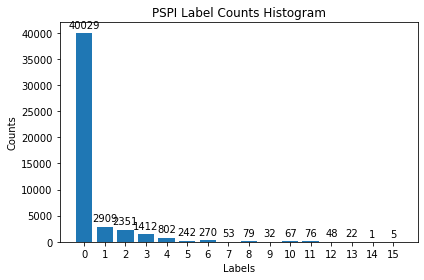

In [6]:
# Extract labels and counts from the dictionary
sorted_label_counts = dict(sorted(label_count.items()))

labels = list(sorted_label_counts.keys())
counts = list(sorted_label_counts.values())

# Create a bar plot (histogram)
plt.bar(labels, counts,tick_label=labels)

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('PSPI Label Counts Histogram')

# Display the plot
plt.tight_layout()

for x, y in zip(labels, counts):
    plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()


**Frames vs PSPI Score**

In [8]:
from matplotlib.layout_engine import ConstrainedLayoutEngine
def print_img_PSPI(img_dir, subject, sequence):
    image_filenames = []
    pain_intensity_labels = []
    average_intensity_scores = []

    sequence_dir = os.path.join(img_dir, subject , sequence)
    image_label_dir = os.path.join(data_root, "Frame_Labels","PSPI", subject, sequence)

    for filename in sorted(os.listdir(sequence_dir)):
        if filename.endswith('.png'): 
            # Load the image
            img = cv2.imread(os.path.join(sequence_dir, filename))
            image_filenames.append(img)

            # Load the pain intensity label from the corresponding text file
            label_filename = os.path.splitext(filename)[0] + '_facs.txt'

            with open(os.path.join(image_label_dir, label_filename), 'r') as label_file:
                pain_intensity = int(float(label_file.read().strip()))
                pain_intensity_labels.append(pain_intensity)

   # Calculate average intensity scores for each batch (for demonstration purposes)
    num_batches = 15
    batch_size = len(image_filenames) // num_batches


    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = start_index + batch_size


        # Calculate the average intensity score for the current batch
        average_intensity = np.mean(pain_intensity_labels[start_index:end_index])
        average_intensity_scores.append(pain_intensity_labels[start_index])

    # Create a smooth curve fitted graph
    x = np.arange(0, num_batches)
    y = average_intensity_scores

    # Use make_interp_spline for a smooth curve fit
    x_smooth = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_smooth)

    fig = plt.figure(figsize=(16, 10),constrained_layout= True)

    gs1 = fig.add_gridspec(2, num_batches,height_ratios=[1,3])

    # Create subplots for the images in the first row
    for i in range(num_batches):
        ax = fig.add_subplot(gs1[0, i])
        ax.imshow(cv2.cvtColor(image_filenames[i * batch_size], cv2.COLOR_BGR2RGB))
        ax.axis('off')

    # Plot the smooth curve in the second row
    ax = fig.add_subplot(gs1[1, :num_batches])
    ax.plot(x_smooth, y_smooth, label='Smooth Curve', linewidth=2)
    ax.scatter(x, y, color='red', marker='o', label='Data Points')
    ax.set_xlabel('Batch Index')
    ax.set_ylabel('Average Pain Intensity')
    ax.set_title('Smooth Curve Fitted Graph - ' + sequence)
    ax.legend()
    ax.grid(True)

    plt.show()



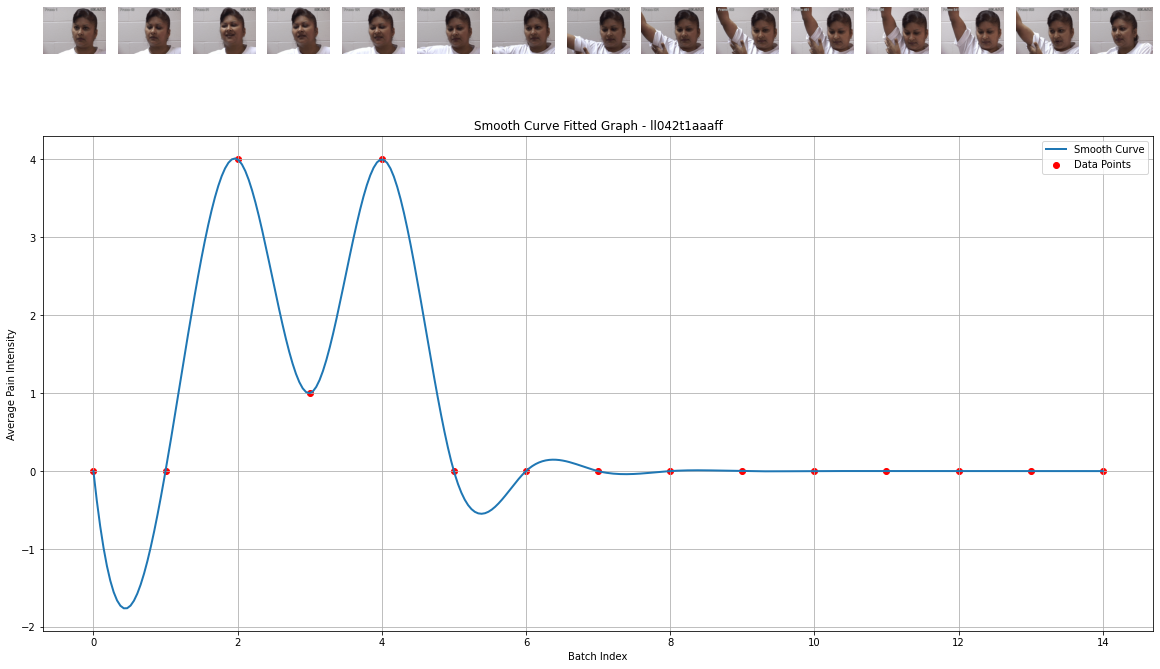

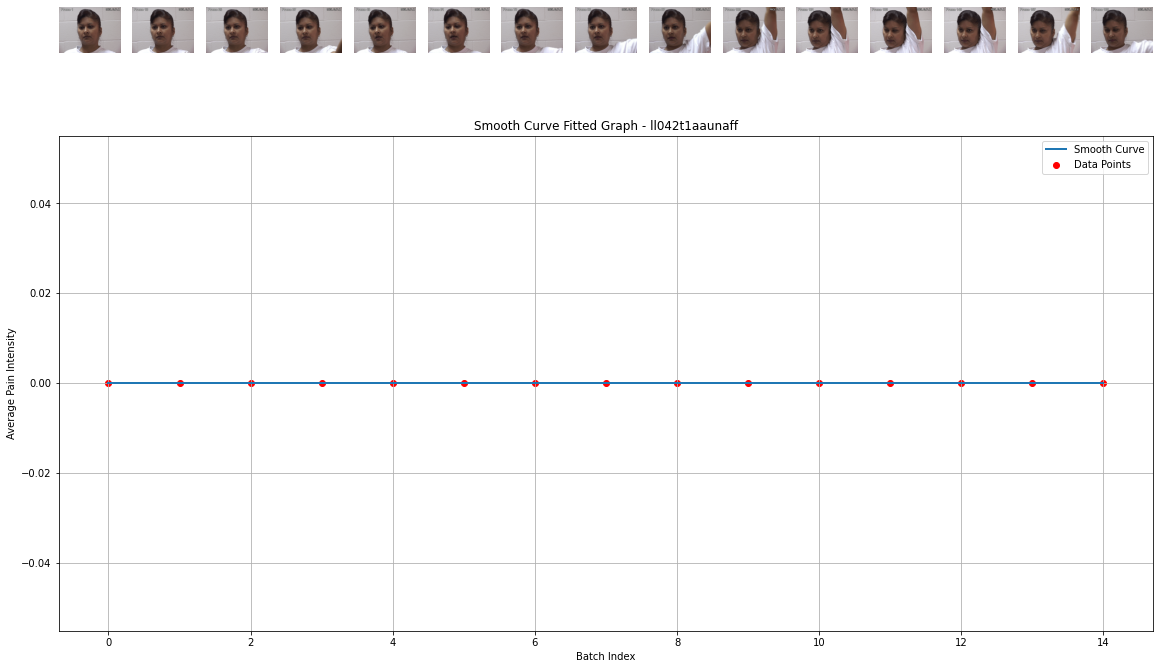

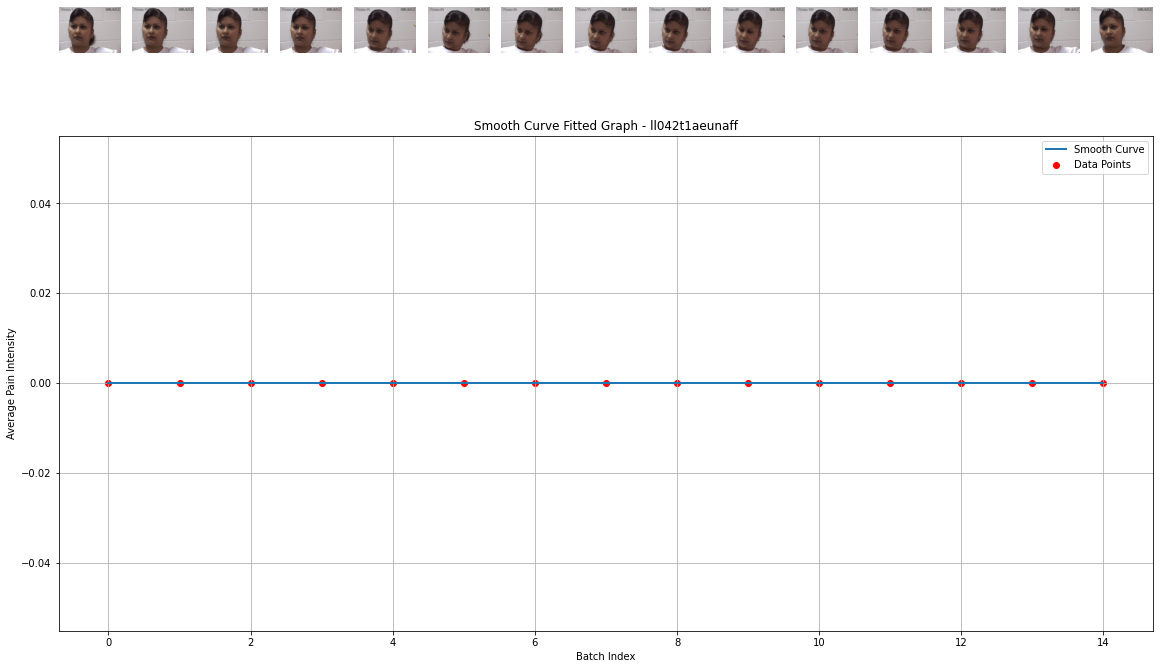

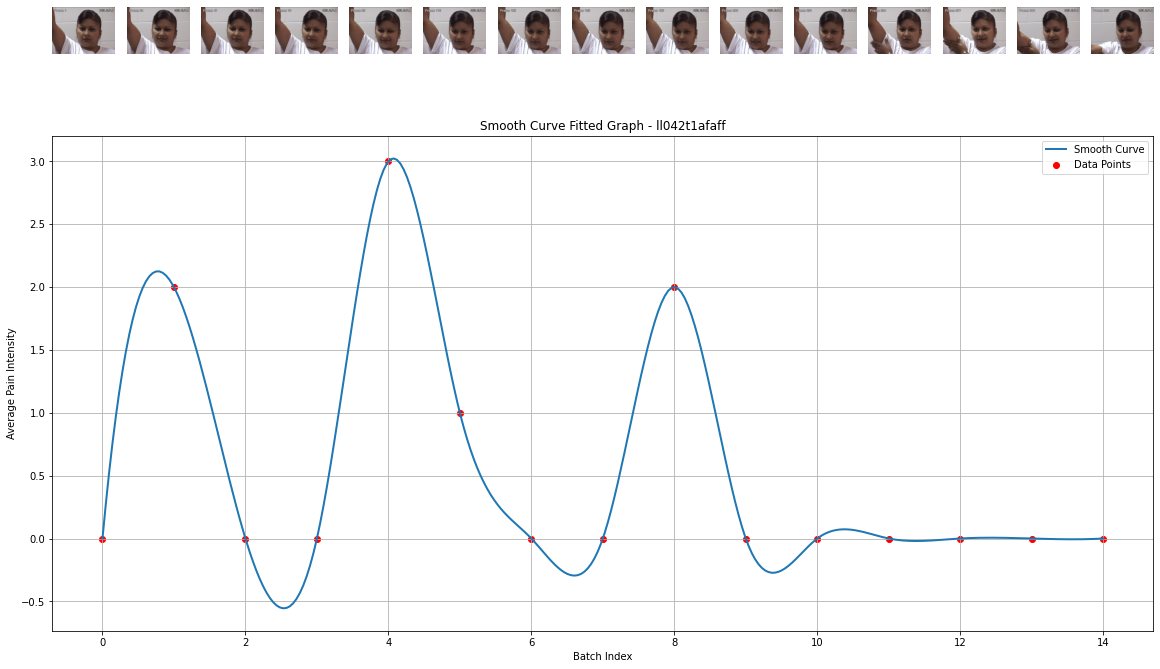

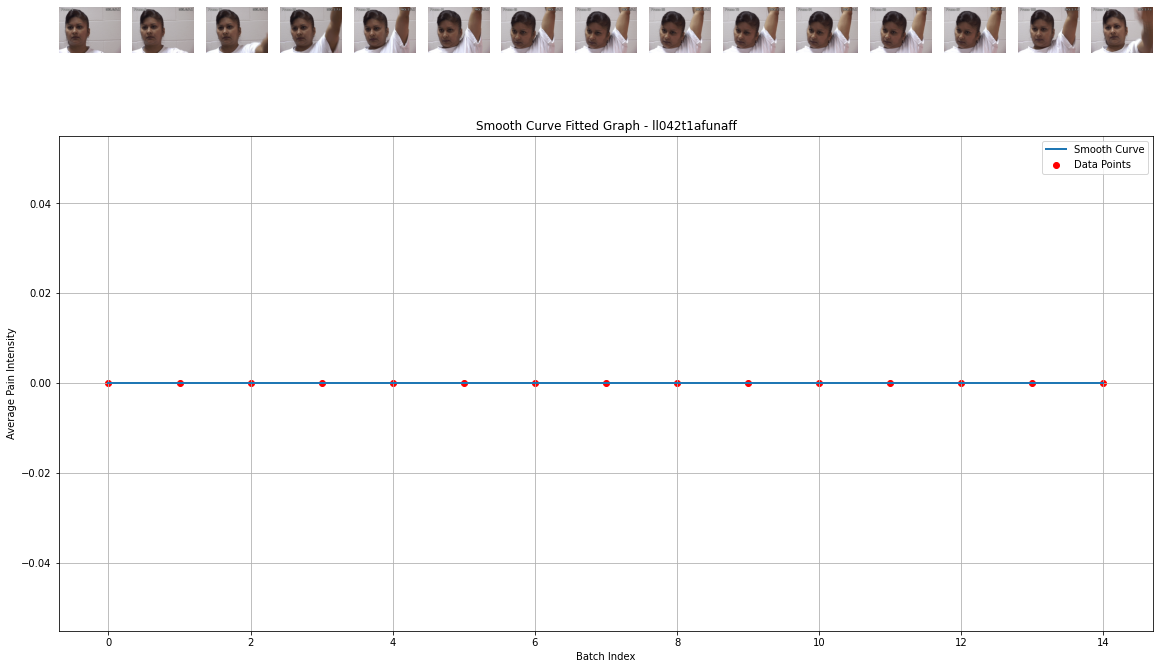

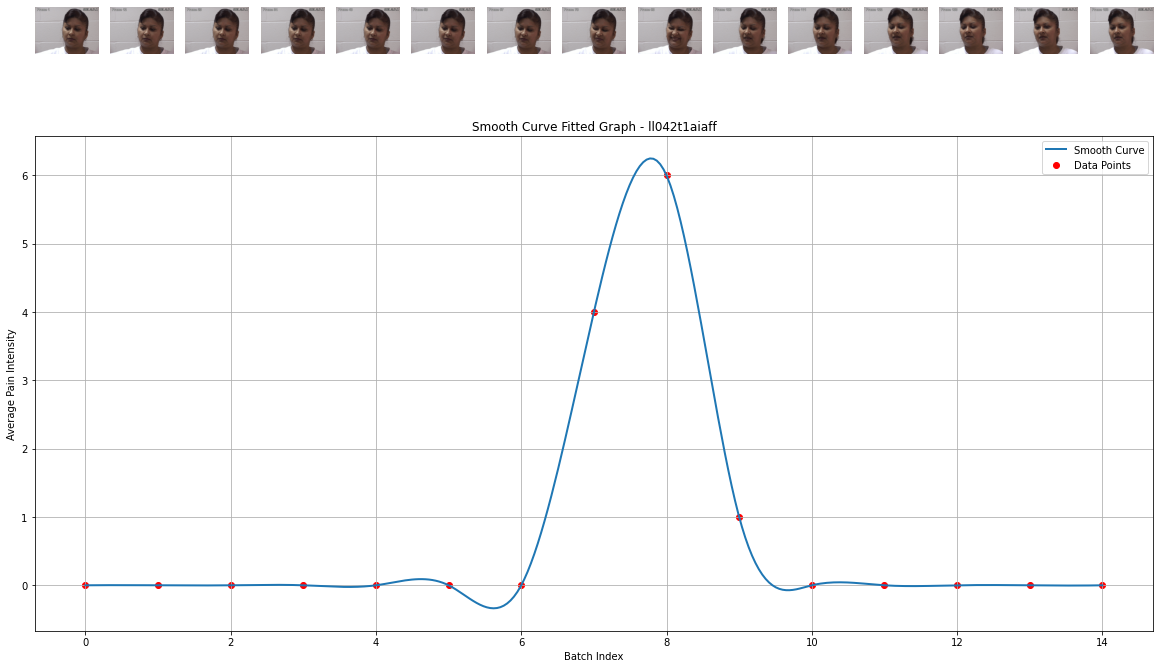

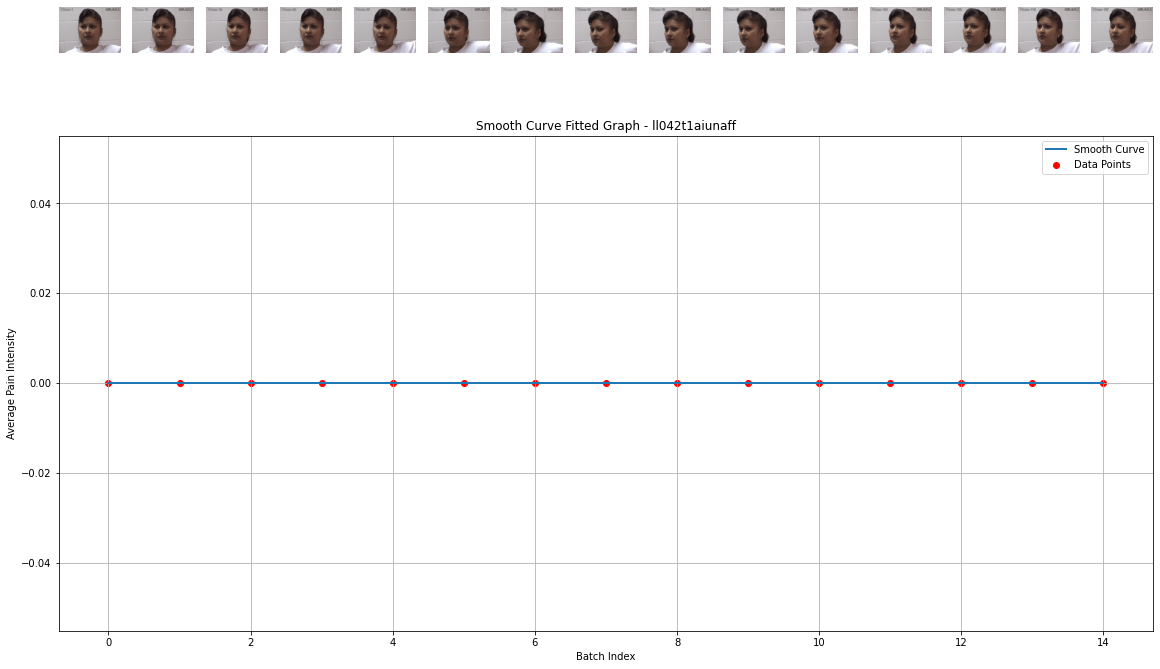

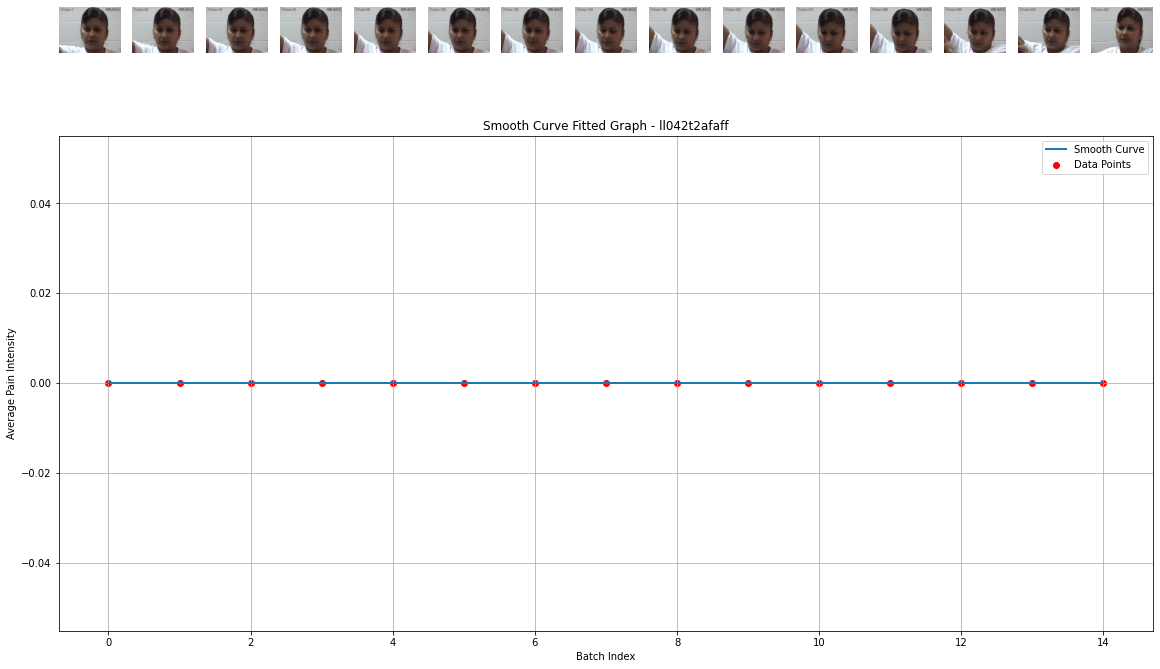

In [9]:
# Initialize lists to store image filenames and pain intensity labels
for subject in images:
    for sequence in os.listdir(img_dir+'/'+subject):
        print_img_PSPI(img_dir, subject, sequence)

    break


# Preprocess the data
- enhance the appearance of the face
- align the face
- crop the face

In [10]:
from tqdm import trange, tqdm_notebook
from time import sleep 

class preprocess():

    def __init__(self, frames, subject_code, sequence_code):
        super(preprocess, self).__init__()
        self.frames = frames
        self.subject_code = subject_code
        self.sequence_code = sequence_code
        # Do landmark detection on the input frames for face recognition proposes
        # self.landmarkDetection()

        self.readLandmarkLabel()

        # Mask the non-face area with black pixels
        self.frames = self.maskFace()

        # Tilt and align the face at centre, then crop the frames according to the face region
        self.frames = self.tiltAlign()
        
        # Resize the frames to 150 x 150 
        self.frames = self.resize_frames()

        # Save the preprocessed images to the define directory
        self.savePreprocessedimages()

    def resize_frames(self):
        frames = []

        for img in self.frames:
            img = cv.resize(img, (150, 150))
            frames.append(img)

        return frames
    def savePreprocessedimages(self):
        print("Saving...")
        path = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\Preprocessed"
        target_dir =""
        # check filepath exist
        if not os.path.exists(path):
            print("checking root...")
            os.mkdir(path)
            
        subject_path = os.path.join(path, self.subject_code)

        if not os.path.exists(subject_path):
            print("checking subject folder")
            os.mkdir(subject_path)

        sequence_path = os.path.join(subject_path, self.sequence_code)

        if not os.path.exists(sequence_path):
            print("checking sequence path")
            os.mkdir(sequence_path)
            target_dir = sequence_path

        print(target_dir)
        for i in trange((len(self.frames)), desc="Saving_" +self.sequence_code ):
            n = f'{i+1:03}'
            cv.imwrite(f'{target_dir}\{self.sequence_code}{n}.png', cv.cvtColor(self.frames[i], cv.COLOR_BGR2RGB))
            sleep(0.01)

    def readLandmarkLabel(self):
        label_path = os.path.join(data_root, "AAM_landmarks", self.subject_code, self.sequence_code)
        all_frames_landmark = []
        frames = self.frames
        n=0
        for frames_label in os.listdir(label_path):
            
            landmarks = []
            landmarks_tuple = []

            img = (frames[n])
            img = img.copy()
            
            if frames_label.endswith(".txt"):
                landmark_file_path = os.path.join(label_path, frames_label)

                with open(landmark_file_path,  'r') as file:
                    landmarks = [list(map(float, line.strip().split())) for line in file]

            if landmarks is not None:
                # Iterate over the detected faces
                for pred in landmarks:
                    
                    x, y = pred
                    landmarks_tuple.append((int(x), int(y)))
                    if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                        cv.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)
            all_frames_landmark.append(landmarks_tuple)
            n += 1

        self.framesLandmark=all_frames_landmark

    def delete_files_in_directory(self, directory_path):
        try:
            with os.scandir(directory_path) as entries:
                for entry in entries:
                    if entry.is_file():
                        os.unlink(entry.path)
                print("All files deleted successfully.")
        except OSError:
            print("Error occurred while deleting files.")

    def landmarkDetection(self):
        print("Detecting landmark...")
        frames = self.frames
        output = []
        framesLandmark = []
        model = FaceAlignment(landmarks_type=LandmarksType.TWO_D, face_detector='blazeface',
                              face_detector_kwargs={'back_model': True}, device='cpu')
        
        for n in trange(len(frames), desc="Detecting landmark_" + self.sequence_code):
            img = (frames[n])
            img = img.copy()
            landmarks = model.get_landmarks(img)
            landmarks_tuple = []
            if landmarks is not None:
                # Iterate over the detected faces
                for pred in landmarks:
                    # Draw landmarks on the frame
                    for point in pred:
                        x, y = point
                        landmarks_tuple.append((int(x), int(y)))
                        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                            cv.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)

            framesLandmark.append(landmarks_tuple)
            output.append(img)
            sleep(0.01)

        self.framesLandmark = framesLandmark

    def tiltAlign(self):
        print("Tilting and aligning...")
        frames = self.frames
        output =[]
        for i in trange(len(frames), desc = "Tilt_align_" + self.sequence_code):
            
            img = frames[i]
            landmarkTuple = self.framesLandmark[i]
            # Landmark index of reight eye and left eye are
            right_eye_cood = [(landmarkTuple[39][0] + landmarkTuple[36][0])/2, (landmarkTuple[39][1] + landmarkTuple[36][1])/2]
            left_eye_cood = [(landmarkTuple[45][0] + landmarkTuple[42][0])/2, (landmarkTuple[45][1] + landmarkTuple[42][1])/2]
            x1, y1 = right_eye_cood
            x2, y2 = left_eye_cood

            a = abs(y1 - y2)
            b = abs(x2 - x1)
            c = math.sqrt(a * a + b * b)

            cos_alpha = (b * b + c * c - a * a) / (2 * b * c)

            alpha = np.arccos(cos_alpha)
            alpha = (alpha * 180) / math.pi
            img = Image.fromarray(img)
            if y1>y2 :
                alpha = -alpha
            img = np.array(img.rotate(alpha))
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            output.append(img)
            
            sleep(0.01)
        return output

    def maskFace(self):
        print("Masking...")
        routes = [i for i in range (16,-1,-1)] + [i for i in range (17,26+1)]

        frames = self.frames
        output = []
        for n in trange(len(frames), desc = "Masking_" + self.sequence_code):
            
            routes_cod = []
            mask = None
            out = None
            landmarks_tuple = self.framesLandmark[n]
            img = (frames[n])
            img = img.copy()
            img2 = img.copy()
            for i in range (0, len(routes)-1):
                source_point = routes[i]
                target_point = routes[i+1]

                source_cod = landmarks_tuple[source_point]
                target_cod = landmarks_tuple[target_point]
                routes_cod.append(source_cod)
                cv.line(img, (source_cod), (target_cod),(255,255,255),2)

            routes_cod = routes_cod+[routes_cod[0]]

            mask = np.zeros((img.shape[0], img.shape[1]))
            mask = cv.fillConvexPoly(mask, np.array(routes_cod),1)
            mask = mask.astype(np.bool_)
            out = np.zeros_like(img)
            out[mask] = img2[mask]
            # plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
            output.append(cv.cvtColor(self.cropFaceArea(out, mask), cv.COLOR_BGR2RGB))
            
            sleep(0.01)
        return output

    def cropFaceArea(self, frame, mask):

        gray = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
        contours, _ = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        # Get the bounding box of the largest contour

        largest_contour = max(contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(largest_contour)

        # Crop the image to the size of the masked face
        cropped_image = frame[y:y+h, x:x+w]

        return cropped_image

    



In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import trange
from tqdm.notebook import trange, tqdm

from time import sleep 

# Load the images into a array
# The structure of the dataset folder
# root > Images > Subject > Sequences > *frame
data_root = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"
img_dir = os.path.join(data_root, "images")

images_data_dir = img_dir # Path that contains all the subject frames of sequences
labels_dir = os.path.join(data_root, 'Sequence_Labels', "VAS")

# Create lists to store preprocessed images and labels
preprocessed_images = []
preprocessed_labels = []

image_subject = os.listdir(images_data_dir)

# Iterate through subject folders (assuming subject folders are labeled with integers)
for i in trange(len(image_subject), desc = "Preprocess progress" ) :
    subject_folder = image_subject[i]
    subject_path = os.path.join(images_data_dir, subject_folder)

    # Skip non-directory files
    if not os.path.isdir(subject_path):
        continue

    # Iterate through sequence folders
    all_sequence_list = os.listdir(subject_path)
    for i in trange(len(all_sequence_list), desc = "Subject_"+subject_folder):
        
        sequence_folder = all_sequence_list[i]
        if os.path.exists(os.path.join("D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\Preprocessed",
                                       subject_folder, sequence_folder)):
            continue
        sequence_path = os.path.join(subject_path, sequence_folder)

        # Initialize a list to store image frames in the current sequence
        sequence_images = []

        # Skip non-directory files
        if not os.path.isdir(sequence_path):
            continue
        
        allframes_path = sorted(os.listdir(sequence_path))

        # Iterate through frames in the sequence
        for i in trange(len(allframes_path),desc='Reading Images_'+sequence_folder):
            frame_filename = allframes_path[i]

            if not frame_filename.endswith('.png'):
                continue

            frame_path = os.path.join(sequence_path, frame_filename)

            # Load the image
            img = cv2.imread(frame_path)

            # Append the image to the images list
            sequence_images.append(img)
            sleep(0.01)


        preprocessing = preprocess(sequence_images, subject_folder, sequence_folder)
       
        sleep(0.01)
    sleep(0.01)


# Data Loading

## Do subset for the data 

Select the frames from 48k images where consist of the PSPI from 0 to 15 (PSPI >5 is considered as 10) 

The data should be selected evenly from 25 subject, and each class should have 400 frames for each classes 

Total number of frames for each class
{0: 40029, 1: 2909, 2: 2351, 4: 802, 5: 242, 6: 270, 3: 1412, 7: 53, 8: 79, 9: 32, 10: 67, 11: 76, 12: 48, 13: 22, 14: 1, 15: 5}

There will be total of 4000 images consist in the dataset

- Relation between the VAS and PSPI, use this as reference to classify the PSPI to 5 differenct classes (https://www.researchgate.net/publication/297637563_Supplemental_Material_Automatic_Pain_Assessment_with_Facial_Activity_Descriptors) 

- {PSPI: 
	- 0: No Pain; 
	- 1: 	Mild Pain (VAS: 1-2); 
	- 2-3: 	Moderate (VAS: 5-3);
	- 4: 	Very Pain (VAS: 6-7);
	- \>=5: Severe Pain (VAS: 8-10)}

- Proposed size of dataset is 6000 images, each class should contains 1200 images

**Define the directory of the dataset**

In [ ]:
import os 

def get_subject_list():
	dataset_root = "D:\\Library\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"
	img_folder_dir = os.path.join(dataset_root, "Images")
	return list(os.listdir(img_folder_dir))

In [ ]:
import os 

dataset_root = "D:\\Library\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"
img_folder_dir = os.path.join(dataset_root, "Images")
PSPI_folder_dir = os.path.join(dataset_root, "Frame_Labels", "PSPI")

# Get all subject 
all_subject = get_subject_list()

**Split the dataset based on label defined with specific number of frames**

In [ ]:
from time import sleep
from tqdm.notebook import trange
import os 
subset_image_dir = {}
subset_label= {}
class_count = {x:0 for x in range(5)}
read_file = {}

dataset_root = "D:\\Library\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\UNBC-McMaster Shoulder Pain Data"
img_folder_dir = os.path.join(dataset_root, "Images")
PSPI_folder_dir = os.path.join(dataset_root, "Frame_Labels", "PSPI")
subject_id = os.listdir(img_folder_dir)
classID = 0

while True:
	count = class_count.get(classID)
	for subject in subject_id:
		temp = {}
		PSPI_sequence_dir = os.path.join(PSPI_folder_dir, subject)
		i = 0
		for sequence_id in os.listdir(PSPI_sequence_dir):
			PSPI_sequence_id_folder = os.path.join(PSPI_sequence_dir, sequence_id)
			temp_img_dir_list =[]
			temp_label_list = []
			for frames in os.listdir(PSPI_sequence_id_folder):
				if i<=48 and count<=1200:
					pain_intensity = 0
					with open(os.path.join(PSPI_sequence_id_folder, frames), 'r') as label_file:
						pain_intensity = int(float(label_file.read().strip()))
					
					append_flag = read_file.get(os.path.join(PSPI_sequence_id_folder, frames))
					# if the PSPI <= 1 AND class ID is the same as the PSPI, then append 
					# if the PSPI == 4 AND class ID == 3, then append 
					if ((pain_intensity <=1 and classID == pain_intensity) or (pain_intensity == 4 and classID == 3)) and append_flag is None:
						temp_img_dir_list.append(os.path.join(img_folder_dir,subject, sequence_id, frames))
						temp_label_list.append(os.path.join(PSPI_sequence_id_folder, frames))
						read_file[os.path.join(PSPI_sequence_id_folder, frames)] = False
						i+=1
						count+=1
					# if 2 <= PSPI <= 3 AND class ID == 2, then append 
					elif (pain_intensity==2 or pain_intensity==3) and classID==2 and append_flag is None:
						temp_img_dir_list.append(os.path.join(img_folder_dir,subject, sequence_id, frames))
						temp_label_list.append(os.path.join(PSPI_sequence_id_folder, frames))
						read_file[os.path.join(PSPI_sequence_id_folder, frames)] = False
						i+=1
						count+=1
					# if  PSPI >= 5 AND class ID == 4, then append 
					elif pain_intensity>=5 and classID == 4 and append_flag is None:
						temp_img_dir_list.append(os.path.join(img_folder_dir,subject, sequence_id, frames))
						temp_label_list.append(os.path.join(PSPI_sequence_id_folder, frames))
						read_file[os.path.join(PSPI_sequence_id_folder, frames)] = False
						i+=1
						count+=1
				else:
					break
			if subset_image_dir.get(subject) is None:
				subset_image_dir[subject] = temp_img_dir_list
				subset_label[subject] = temp_label_list
			else:
				update_img_list = subset_image_dir.get(subject)
				update_img_list.extend(temp_img_dir_list)
				subset_image_dir.update({subject:(update_img_list)})

				update_label_list = subset_label.get(subject)
				update_label_list.extend(temp_label_list)
				subset_label.update({subject:(update_label_list)})
			if i == 49 or count>=1200:
				break
		
	# Each class should not more than 1200 frames
	if count<1200 and not count==class_count.get(classID):
		class_count.update({classID:count})
		print(class_count)
		print("continue")
		continue
	# Goes to the next class if the last class of pain not yet reach
	elif classID < 4 :
		class_count.update({classID:count})
		print(class_count)
		print("next")
		classID+=1
	# Terminate if both criteria above have fulfilled 
	else:
		break	

{0: 1201, 1: 0, 2: 0, 3: 0, 4: 0}
next
{0: 1201, 1: 838, 2: 0, 3: 0, 4: 0}
continue
{0: 1201, 1: 1201, 2: 0, 3: 0, 4: 0}
next
{0: 1201, 1: 1201, 2: 984, 3: 0, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 0, 4: 0}
next
{0: 1201, 1: 1201, 2: 1201, 3: 508, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 619, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 668, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 717, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 766, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 0}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 0}
next
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 550}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 788}
continue
{0: 1201, 1: 1201, 2: 1201, 3: 802, 4: 895}
continue


**Write into the csv file**

In [ ]:
import csv
def write_subject(subject, data_list, label_list):
	with open('subset_list.csv', 'a', encoding='UTF8',newline='') as f:
		writer = csv.writer(f)
		for i in range(len(data_list)):
			writer.writerow([subject, (data_list[i].split("_")[0] + ".png").replace("Images","Preprocessed"), label_list[i]])

def reset_csv():
	with open('subset_list.csv', 'w', encoding='UTF8',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(["subject", "path", "label"])

for subject in subset_image_dir.keys():
	write_subject(subject, subset_image_dir.get(subject), subset_label.get(subject))

Moves all written data in CSV file into another subset folder

In [ ]:
import shutil
import csv

image_dest = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\subset\\Images"
label_dest = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\subset\\Labels"

with open ("subset_list.csv") as csv_file:
	csv_reader = csv.reader(csv_file, delimiter=',')
	next(csv_reader)

	for row in csv_reader:
		if not os.path.exists(os.path.join(image_dest, row[0])):
			os.mkdir(os.path.join(image_dest, row[0]))
			os.mkdir(os.path.join(label_dest, row[0]))

		shutil.copy(row[1], os.path.join(image_dest, row[0]))
		shutil.copy(row[2], os.path.join(label_dest, row[0]))



## Load data into pickel file

In [1]:
import os
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from torchvision import transforms
from sklearn.metrics import accuracy_score

from tqdm.notebook import trange
from tqdm import tnrange
from time import sleep

data_root = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\subset\\Images"
label_root = "D:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Dataset\\subset\\Labels"

def load_subject_data(subject_name):
    subject_dir = os.path.join(data_root,subject_name)
    frames = []  # Load frames from the subject's directory
    pain_intensity_labels = []  # Load corresponding labels
    all_frames = sorted(os.listdir(subject_dir))
    for i in trange(len(all_frames),desc='Subject level progress'):
        
        filename = all_frames[i]
        if filename.endswith(".png"):
            try:
                # Load the pain intensity label from the corresponding text file
                label_filename = os.path.splitext(filename)[0] + '_facs.txt'
                label_path = os.path.join(label_root, subject_name)
                with open(os.path.join(label_path, label_filename), 'r') as label_file:
                    pain_intensity = int(float(label_file.read().strip()))
                    pain_intensity_labels.append(10 if pain_intensity>10 else pain_intensity)

                # Load the image
                img = cv2.imread(os.path.join(subject_dir, filename))
                img = cv2.resize(img, (150,150))
                frames.append(img)
            except Exception as e:
                print(e)
            finally:
                sleep(0.01)
                continue

    return frames, pain_intensity_labels

To get the subject list in the subset of data

In [2]:
import csv 
def get_subject_list():
	
	subject = []
	with open ("subset_list.csv") as csv_file:
		csv_reader = csv.reader(csv_file, delimiter=',')
		next(csv_reader)

		for row in csv_reader:
			subject.append(row[0])
	
	
	return list(set(subject))

In [ ]:
import numpy as np 
from tqdm.notebook import tnrange
# Define empty variable to load Data
all_frames = []
all_labels = []
all_subjects = []
subject_directories = get_subject_list()

for i in tnrange(len(subject_directories),desc='progress'):
    subject_name = subject_directories[i]
    try:
        frames, labels = load_subject_data(subject_name)
    except Exception as e:
        print(e)
        continue        

    all_frames.extend(frames)
    all_labels.extend(labels)
    all_subjects.extend([i] * len(frames))  # Assign a unique identifier to each subject
    sleep(0.01)

all_frames = np.array(all_frames)
all_labels = np.array(all_labels)
all_subjects = np.array(all_subjects)

Save the loaded data into pickel file

In [5]:
import pickle

# Save the variable to a new file
pickle.dump(all_frames, open('image.pkl', 'wb'))
pickle.dump(all_labels, open('label.pkl', 'wb'))
pickle.dump(all_subjects, open('subject.pkl', 'wb'))


# Model Training

Load data from pickel file

In [24]:
import pickle
all_frames = pickle.load(open('../Execute/image150.pkl', 'rb'))
all_labels = pickle.load(open('../Execute/label150.pkl', 'rb'))
all_subjects = pickle.load(open('../Execute/subject150.pkl', 'rb'))

Append new label to the data

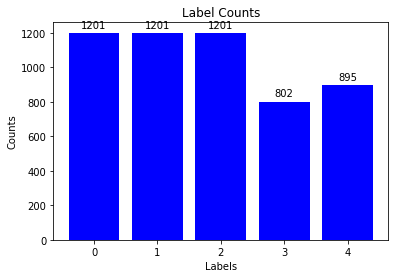

In [25]:
import pandas as pd
from matplotlib import pyplot as plt

# Relabel the class to be more balance 
new_class=[]
for n in range (len(all_labels)):
	temp = all_labels[n]
	if temp == 0: # No Pain
		new_class.append(0)
	elif temp == 1: # Mild Pain
		new_class.append(1)
	elif temp == 2 or temp == 3: # Moderate Pain 
		new_class.append(2)
	elif temp == 4: # Very Pain
		new_class.append(3)
	else: # PSPI >= 5 : Severe Pain
		new_class.append(4)

# Create a sample DataFrame
data = {'labels': new_class}
df = pd.DataFrame(data)

# Using value_counts() to count occurrences
label_counts = df['labels'].value_counts().to_dict()
# Create a bar chart
labels, counts = zip(*label_counts.items())
plt.bar(labels, counts, color='blue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Counts')
for x, y in zip(labels, counts):
    plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Show the plot
plt.show()

## Visualize the loaded data

Display the number of each class by each subject

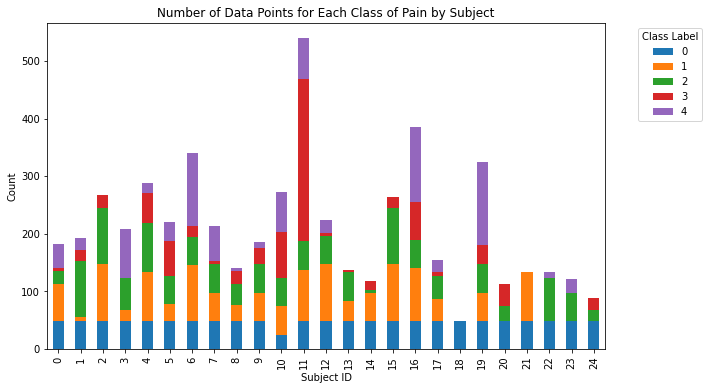

In [26]:
# analyse each subject contains how many types of classes
import pandas as pd
from matplotlib import pyplot as plt
# Sample DataFrame (replace this with your actual data)
data = {
    'Subject_ID': all_subjects,
    'Class_Label': new_class,
}

df = pd.DataFrame(data)

# Group by Subject_ID and Class_Label, and count the number of occurrences
subject_class_counts = df.groupby(['Subject_ID', 'Class_Label']).size().reset_index(name='Count')

# Display the result
pivot_df = subject_class_counts.pivot(index='Subject_ID', columns='Class_Label', values='Count').fillna(0)

# Plot the bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Data Points for Each Class of Pain by Subject')
plt.xlabel('Subject ID')
plt.ylabel('Count')
plt.legend(title='Class Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Display sample frame for each class 

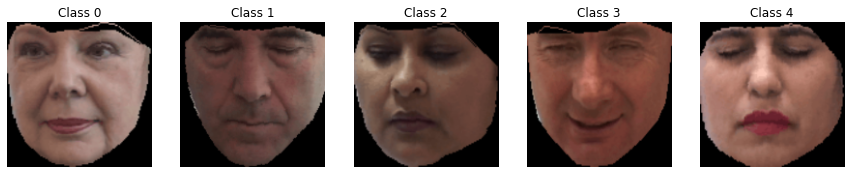

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Assuming you have a dataset X_train and y_train
# X_train: Features, y_train: Labels

# Find the indices of the first occurrence of each class
class_indices = [new_class.index(i, all_subjects.tolist().index(i+2)) for i in range(5)]

# Plot one example for each class
plt.figure(figsize=(15, 5))
for i, idx in enumerate(class_indices, 1):
    plt.subplot(1, 5, i)
    plt.imshow(cv2.cvtColor(all_frames[idx], cv2.COLOR_BGR2RGB))
    plt.title(f'Class {new_class[idx]}')
    plt.axis('off')

plt.show()

Display 10 frames from each subject 

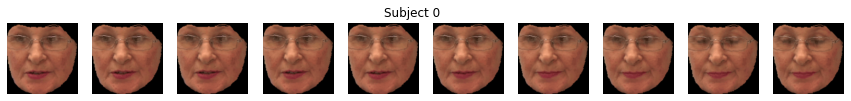

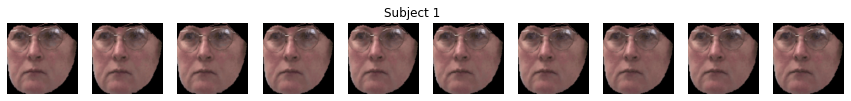

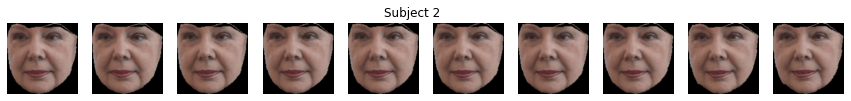

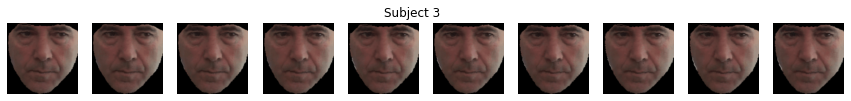

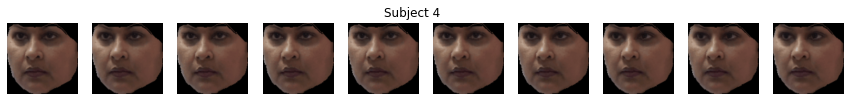

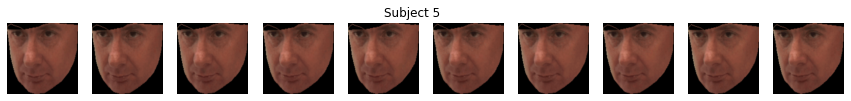

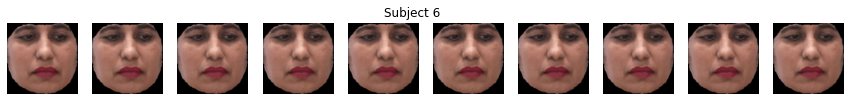

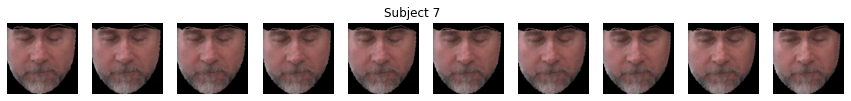

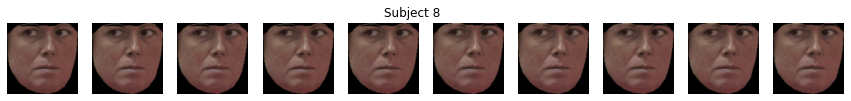

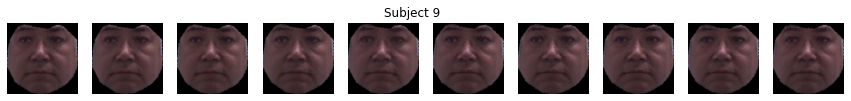

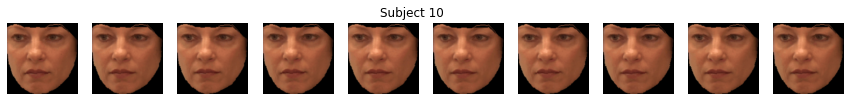

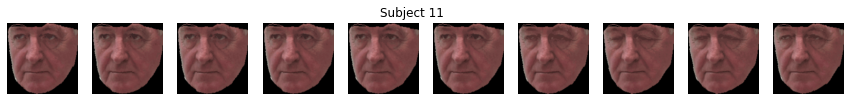

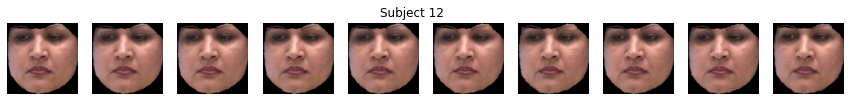

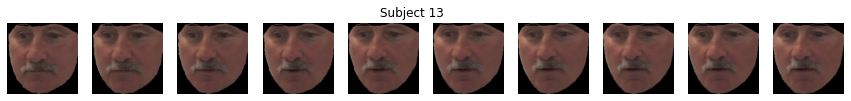

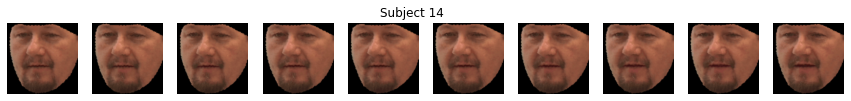

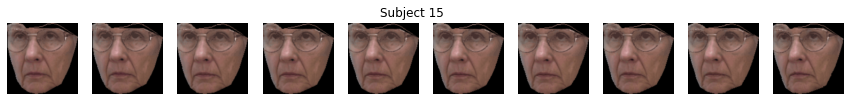

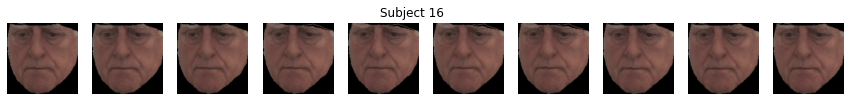

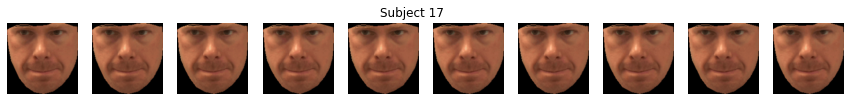

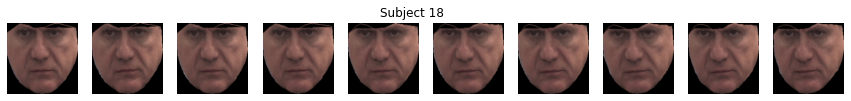

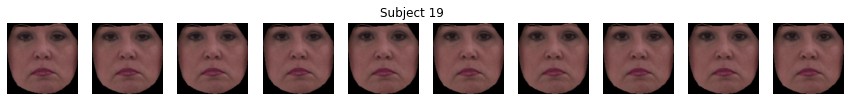

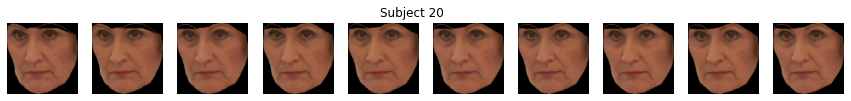

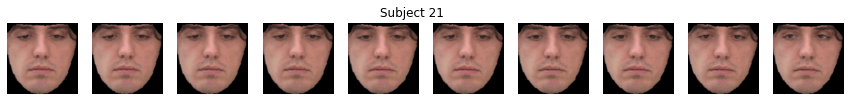

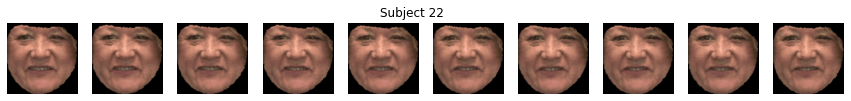

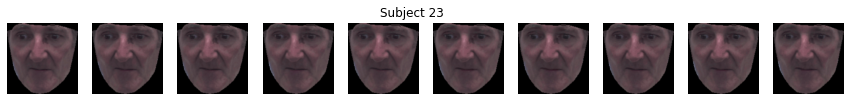

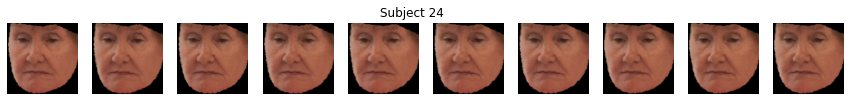

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Number of photos to print for each subject
photos_per_subject = 10

# Dictionary to store selected images for each subject
selected_images = {}

# Iterate through the dataset and select 10 images for each subject
for img, label in zip(all_frames, all_subjects):
    if label not in selected_images:
        selected_images[label] = []
    if len(selected_images[label]) < photos_per_subject:
        selected_images[label].append(img)

# Display the selected images
for subject, images_list in selected_images.items():
    plt.figure(figsize=(15, 1.5))
    plt.suptitle(f"Subject {subject}")
    for i, img_path in enumerate(images_list, 1):
        # If images are stored as file paths
        if isinstance(img_path, str):
            image = cv2.imread(img_path)
        # If images are stored as NumPy arrays
        elif isinstance(img_path, np.ndarray):
            image = img_path
        else:
            raise ValueError("Unsupported image format")

        # Display the image
        plt.subplot(1, photos_per_subject, i)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")

    plt.show()

Convert the frames into one channel grayscale image

In [41]:
gryscale_frames = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in all_frames]

Display before and after

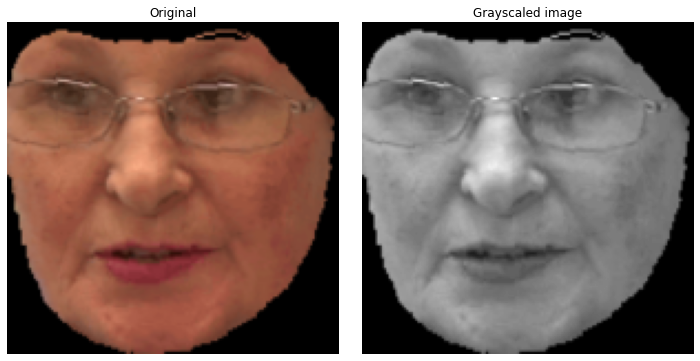

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the left subplot
ax[0].set_title('Original')
ax[0].imshow(cv2.cvtColor(all_frames[1], cv2.COLOR_BGR2RGB))
ax[0].axis('off')  # Turn off axis labels

# Display the second image on the right subplot
ax[1].set_title("Grayscaled image")
ax[1].imshow(gryscale_frames[1], cmap='gray')
ax[1].axis('off')  # Turn off axis labels

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Display 10 converted images from each subject

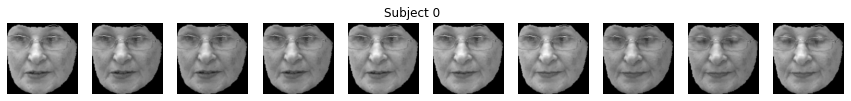

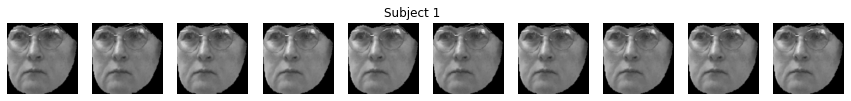

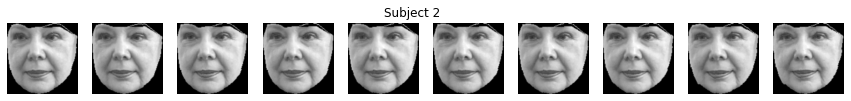

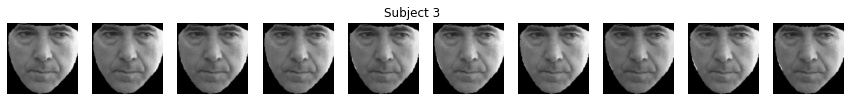

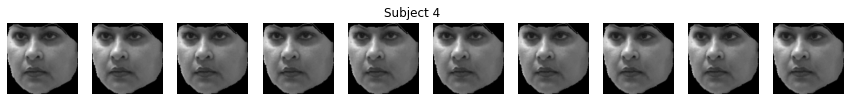

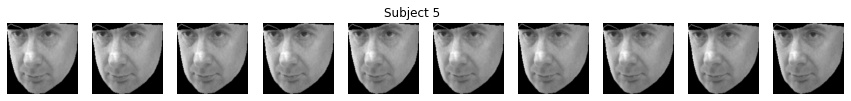

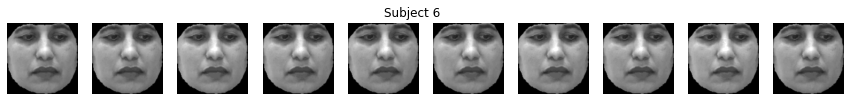

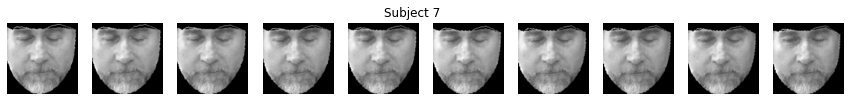

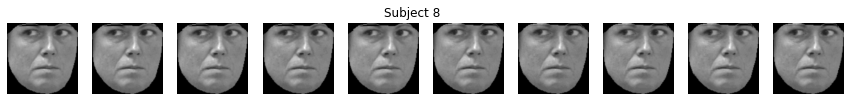

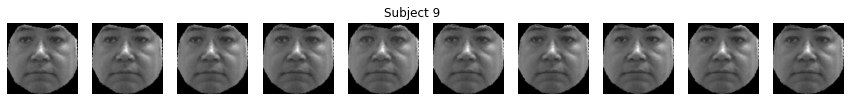

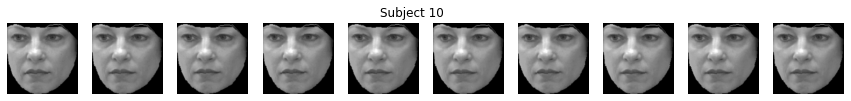

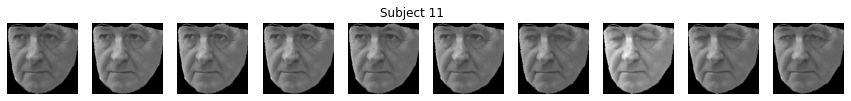

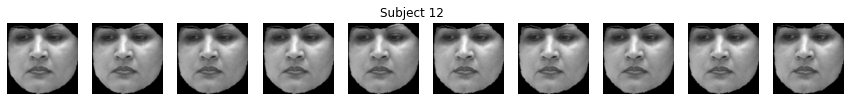

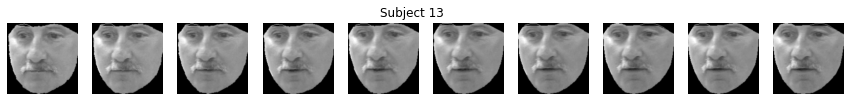

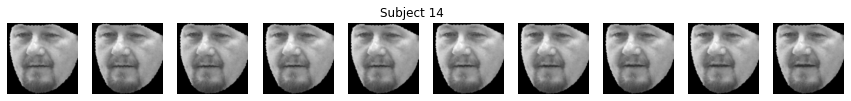

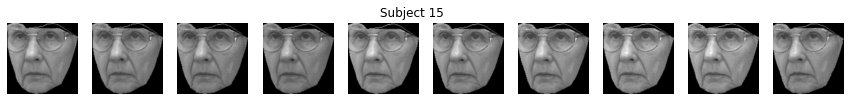

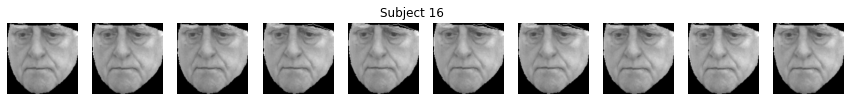

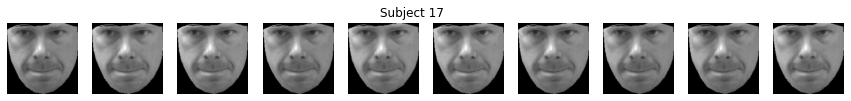

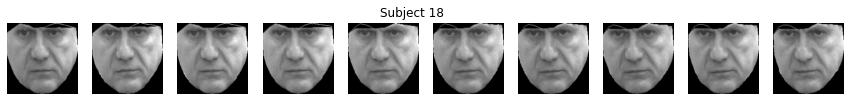

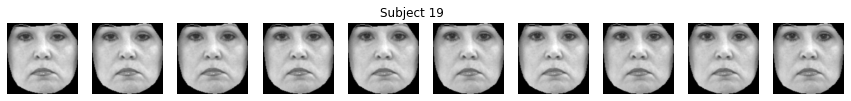

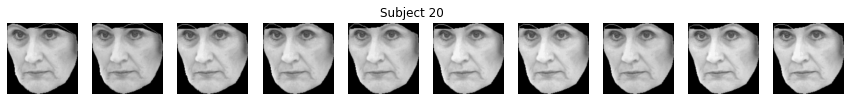

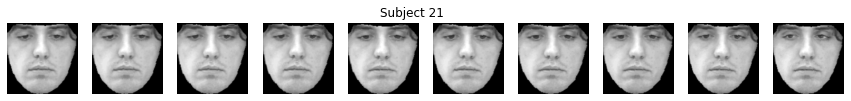

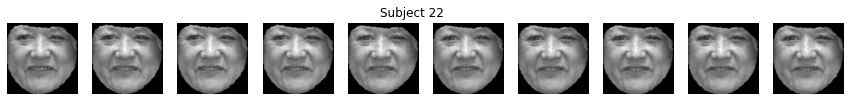

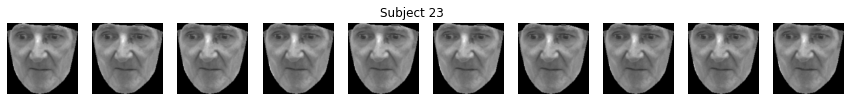

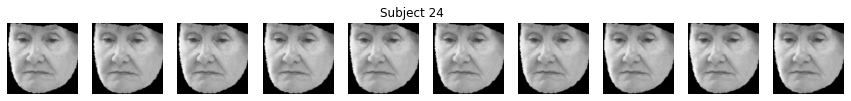

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Number of photos to print for each subject
photos_per_subject = 10

# Dictionary to store selected images for each subject
selected_images = {}

# Iterate through the dataset and select 10 images for each subject
for img, label in zip(gryscale_frames, all_subjects):
    if label not in selected_images:
        selected_images[label] = []
    if len(selected_images[label]) < photos_per_subject:
        selected_images[label].append(img)

# Display the selected images
for subject, images_list in selected_images.items():
    plt.figure(figsize=(15, 1.5))
    plt.suptitle(f"Subject {subject}")
    for i, img_path in enumerate(images_list, 1):
        # If images are stored as file paths
        if isinstance(img_path, str):
            image = cv2.imread(img_path)
        # If images are stored as NumPy arrays
        elif isinstance(img_path, np.ndarray):
            image = img_path
        else:
            raise ValueError("Unsupported image format")

        # Display the image
        plt.subplot(1, photos_per_subject, i)
        plt.imshow(image, cmap='gray')
        plt.axis("off")

    plt.show()

In [47]:
# split into test and train-val set

temp_dataset = all_frames 

x_test = []
Y_test = []
subject_train_val = []
x_train_val = []
Y_train_val = []

for i in range(len(gryscale_frames)):
    #take subject 0, 18, 22, 21, 24 and 20 to be test dataset
    if(all_subjects[i] == 0 or all_subjects[i] == 18 or all_subjects[i] == 22 
       or all_subjects[i] == 21 or all_subjects[i] == 24 or all_subjects[i] == 20):
        x_test.append(gryscale_frames[i])
        Y_test.append(new_class[i])
    else: # the remaining data is the train-validation dataset
        subject_train_val.append(all_subjects[i])
        x_train_val.append(gryscale_frames[i])
        Y_train_val.append(new_class[i])
        
print("Test set size =", len(x_test), "\nTrain-validation set size =", len(x_train_val))
print("Number of classes in test set:", len(set(Y_test)))
print("Number of classes in train_validation set: ", len(set(Y_train_val)))


Test set size = 700 
Train-validation set size = 4600
Number of classes in test set: 5
Number of classes in train_validation set:  5


In [48]:
import numpy as np

subject_train_val = np.array(subject_train_val)

x_test32 = np.array(x_test, dtype=np.float32)
x_train_val32 = np.array(x_train_val, dtype=np.float32)

Y_test16 = np.array(Y_test, dtype=np.int16)
Y_train_val16 = np.array(Y_train_val, dtype=np.int16)

## Define Gabor filter

Transform the image by applying the gabor filter 

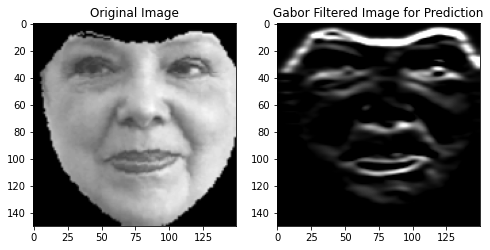

In [49]:
# Normalize the frames
# x_test1 = x_test32 / 255.0
# x_train_val1 = x_train_val32 / 255.0

# Define Gabor filter parameters
ksize = 31  		# Kernel size
sigma = 1.5  		# Standard deviation of the Gaussian envelope
theta = np.pi / 2 	# Orientation of the Gabor filter np.pi / 4
lambd = 20			# Wavelength of the sinusoidal factor
gamma = 0.5 		# Spatial aspect ratio

# Create Gabor kernel
gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma)
x_train_val1 = [cv2.filter2D(input_image, cv2.CV_8U, gabor_kernel) for input_image in x_train_val32]
x_test1 = [cv2.filter2D(input_image, cv2.CV_8U, gabor_kernel) for input_image in x_test32]

# Display the original and Gabor-filtered images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_train_val32[300], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(x_train_val1[300], cmap='gray')
plt.title('Gabor Filtered Image for Prediction')

plt.show()

x_test1 = (np.array(x_test1,dtype=np.float32))/255
x_train_val1 =( np.array(x_train_val1,dtype=np.float32))/255

## Model Training

Define the model architecture

In [50]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, AveragePooling2D, SpatialDropout2D
from keras.regularizers import l1_l2
import tensorflow as tf

def PainScorePredictor(dropout_rate=0.5, l1=0.08, l2=0.07):
    model = Sequential()

    model.add(Conv2D(8, (5,5), strides=(1,1), padding='same',activation='relu', input_shape=(150, 150, 1),
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(MaxPooling2D((3,3), strides=(2, 2)))
    model.add(SpatialDropout2D(0.7))

    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(SpatialDropout2D(0.7))

#     model.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu'
#                      ,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)))
# #     model.add(SpatialDropout2D(dropout_rate))
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
#     model.add(Dense(16, activation='relu')) #64
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation='softmax'))

    return model
model = PainScorePredictor()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 8)       208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 8)         0         
 D)                                                              
                                                                 
 spatial_dropout2d (Spatial  (None, 74, 74, 8)         0         
 Dropout2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 16)        0         
 g2D)                                                            
                                                        

In [51]:
# train by using pretrained model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam

def initialise_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape = (120,120, 3))

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False
        
    return model


In [52]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [53]:
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

Training with the predefined model

In [ ]:
import tensorflow as tf
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping
from keras.optimizers.schedules import ExponentialDecay
from keras import metrics
from sklearn.metrics import f1_score

seed_value = 50
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
n_fold = len(set(subject_train_val))
print("Number of fold:", n_fold)
# Assuming your data is loaded into X and y
# X: Features, y: Labels
X = x_train_val1
y = tf.keras.utils.to_categorical(Y_train_val16, 5)

all_model = [PainScorePredictor() for n in range(n_fold)]

# Set up k-fold cross-validation
gkf = GroupKFold(n_splits=n_fold)
sgkf = StratifiedGroupKFold(n_splits=n_fold, random_state=seed_value,shuffle=True)

hist = []

# Training loop with k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, Y_train_val16, groups=subject_train_val)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    print("Current fold:", (fold+1))
#     if not fold == 9 and not fold ==10 and not fold == 13:
#         continue
    class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_val16), y=Y_train_val16[train_idx])
    class_weight_dict = dict(zip(np.unique(Y_train_val16), class_weights))
    
#     print("Class Weight:", class_weight_dict)
#     print("Training size:",len(train_idx), "Validation Size:", len(val_idx))
    
    # Compile and fit the model
    X_train = tf.convert_to_tensor(X_train)
    y_train = tf.convert_to_tensor(y_train)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train),reshuffle_each_iteration=True).batch(80)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
    
    # tf.keras.metrics.F1Score(average=None, threshold=None, name='f1_score', dtype=None)]
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)  
    all_model[fold].compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(
    average='weighted', threshold=0.4, name='f1_score', dtype=None)])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    plot_learning = PlotLearning()

#     class_weight=class_weight_dict,
    hist.append(all_model[fold].fit(train_dataset, class_weight=class_weight_dict,epochs=50, batch_size=100,shuffle=True,
                          validation_data=(X_val, y_val),callbacks=[early_stopping,plot_learning]))


# Model Evaluation

- Display the training and validation loss graph for each fold
- Display the training and validation F1 Score for each fold

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os 


lg_path = "../Execute/history/loss_graph"

if not os.path.exists(lg_path):
    os.mkdir(lg_path)
    
for n in range (0, len(hist)):
    temp = hist[n]

    # Plot training-validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(temp.history['loss'], label='Training Loss')
    plt.plot(temp.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {n + 1} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.text(0.05, -0.05,
                 f'Training Loss: {temp.history["loss"][-1]:.4f}\n'
                 f'Validation Loss: {temp.history["val_loss"][-1]:.4f}\n'
                 f'Training F1 Score: {temp.history["f1_score"][-1]:.4f}\n'
                 f'Validation F1 Score: {temp.history["val_f1_score"][-1]:.4f}',
                 transform=plt.gcf().transFigure, fontsize=12,
                 verticalalignment='center', horizontalalignment='left')
    
    # Plot F1 score for training and validation
    plt.subplot(1, 2, 2)
    plt.plot(temp.history['f1_score'], label='Training F1 Score')
    plt.plot(temp.history['val_f1_score'], label='Validation F1 Score')
    plt.title(f'Fold {n + 1} - Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()        
    plt.tight_layout()
    plt.savefig( lg_path+ '/Loss Across Fold_'+ str(n+1)+ '.png',bbox_inches='tight')
    plt.show()


Use test set data to evaluate the model performance by using confusion metric

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

cf_path = "../Execute/history/confusion_matrix"
if not os.path.exists(cf_path):
    os.mkdir(cf_path)

for i in range(len(hist)):
    y_pred = all_model[i].predict(x_test1)

    predicted_classes = tf.argmax(y_pred, axis=1)
    # Assuming you have computed predicted_classes and y_test_subject
    accuracy = accuracy_score(Y_test16, predicted_classes)
    f1 = f1_score(Y_test16, predicted_classes, average='weighted')
    cm = confusion_matrix(Y_test16, predicted_classes)

    # Get the class labels
    class_labels = np.unique(Y_test16)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix Model {i+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.text(0.05, -0.05,
            f'Accuracy: {accuracy * 100:.2f}%\n'
            f'F1 Score: {f1:.4f}',
            transform=plt.gcf().transFigure, fontsize=12,
            verticalalignment='center', horizontalalignment='left')
    
    plt.savefig(cf_path + '/CM Fold_'+ str(i+1)+ '.png',bbox_inches='tight')
    plt.show()

In [ ]:
import os 
path = "../Execute/history/model"
if not (os.path.exists(path)):
    os.mkdir(path)
for i in range(len(all_model)):
    all_model[i].save(f'{path}/model_fold_{i+1}.h5')

# Documentation
Save all the generated result file and trained model, and compressed them in to a zip file

In [58]:
from datetime import datetime
import pytz
from pytz import timezone

now_utc = datetime.now(timezone('UTC'))

# Converting to Asia/Kolkata time zone
now_asia = now_utc.astimezone(timezone('Asia/Kuala_Lumpur'))


# dd/mm/YY H:M:S
dt_string = now_asia.strftime("%d-%m-%Y_%H-%M-%S")
print("date and time =", dt_string)

date and time = 16-01-2024_14-55-15


In [60]:
import shutil

# Zip file name
zip_file_name = f'history_{dt_string}'

shutil.make_archive(zip_file_name, 'zip', '..\Execute\history')

'd:\\Library\\Documents\\UM Lecture Notes & Tutorial\\FYP\\Src\\Automated-Recognition-of-Facial-Expression-of-Pain\\Module\\Execute\\history_16-01-2024_14-55-15.zip'